In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Specify dtype option on import or set low_memory=False.
pd.options.mode.chained_assignment = None  # default='warn'

import math
import scipy

# Datviz purposes
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import missingno as msno

import tensorflow as tf
from tensorflow import keras

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import train_test_split

In [2]:
try :
    train_data = pd.read_csv("/kaggle/input/joints-cleaned/train_data.csv")
    test_data = pd.read_csv("/kaggle/input/joints-cleaned/test_data.csv")
    submission_sample_data = pd.read_csv("/kaggle/input/joints-cleaned/sample_submission.csv") # For Kaggle

except :
    train_data = pd.read_csv("../4-FeatureEng/train_data.csv", low_memory=False)
    test_data = pd.read_csv("../4-FeatureEng/test_data.csv", low_memory=False) # For local

In [3]:
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (335455, 30)
Test data shape:  (242082, 30)


In [4]:
print("Train data columns: ", train_data.columns)
print("Test data columns: ", test_data.columns)

Train data columns:  Index(['floors_before_eq(total)', 'old_building', 'plinth_area(ft^2)',
       'height_before_eq(ft)', 'land_surface_condition', 'type_of_foundation',
       'type_of_roof', 'type_of_ground_floor', 'type_of_other_floor',
       'position', 'building_plan_configuration', 'legal_ownership_status',
       'has_secondary_use', 'type_of_reinforcement_concrete',
       'residential_type', 'no_family_residing', 'public_place_type',
       'industrial_use_type', 'govermental_use_type',
       'flexible_superstructure', 'wall_binding', 'wall_material',
       'damage_grade', 'ismorethanplintharea', 'reconstruction',
       'major_repair', 'minor_repair', 'no_need', 'height_per_floor',
       'pressure'],
      dtype='object')
Test data columns:  Index(['id', 'floors_before_eq(total)', 'old_building', 'plinth_area(ft^2)',
       'height_before_eq(ft)', 'land_surface_condition', 'type_of_foundation',
       'type_of_roof', 'type_of_ground_floor', 'type_of_other_floor',
       

In [5]:
# # Doing feature selection
# feature_selection_train = ['floors_before_eq(total)','plinth_area(ft^2)','height_before_eq(ft)','old_building',
#                            'land_surface_condition', 'type_of_foundation',
#                            'type_of_roof', 'type_of_ground_floor', 'type_of_other_floor',
#                            'position','has_secondary_use', 'type_of_reinforcement_concrete', 
#                            'flexible_superstructure', 'wall_binding', 'wall_material',
#                            'damage_grade', 'ismorethanplintharea', 'reconstruction',
#                            'major_repair', 'minor_repair', 'no_need', 'height_per_floor',
#                            'pressure']
# feature_selection_test = ['floors_before_eq(total)','plinth_area(ft^2)','height_before_eq(ft)','old_building',
#                           'id','land_surface_condition', 'type_of_foundation',
#                            'type_of_roof', 'type_of_ground_floor', 'type_of_other_floor',
#                            'position','has_secondary_use', 'type_of_reinforcement_concrete', 
#                            'flexible_superstructure', 'wall_binding', 'wall_material'
#                            ,'ismorethanplintharea', 'reconstruction',
#                            'major_repair', 'minor_repair', 'no_need', 'height_per_floor',
#                            'pressure']

# train_data = train_data[feature_selection_train]
# test_data = test_data[feature_selection_test]

## One-hot encoding

In [6]:
one_hot = ['building_plan_configuration', 'residential_type', 'public_place_type', 
           'industrial_use_type', 'govermental_use_type','legal_ownership_status']

train_data = pd.get_dummies(train_data, columns=one_hot)
test_data = pd.get_dummies(test_data, columns=one_hot)

## RobustScaler

In [7]:
# use robust scaler

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

#'floors_before_eq(total)', 'old_building', 'plinth_area(ft^2)','height_before_eq(ft)', 'height_per_floor','pressure'
transform = ['floors_before_eq(total)', 'old_building', 'plinth_area(ft^2)','height_before_eq(ft)', 'height_per_floor','pressure']

train_data[transform] = scaler.fit_transform(train_data[transform])
test_data[transform] = scaler.transform(test_data[transform])

# Data preparation

In [8]:
# copying the original dataset into X
X=train_data.copy()
# droping building_id and dependent variable damage_grade
# independant variables
X=X.drop(["damage_grade"],axis=1)
# dependent variable
y=train_data["damage_grade"]

In [9]:
x_train, x_test,y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state = 42)

# Random Forest

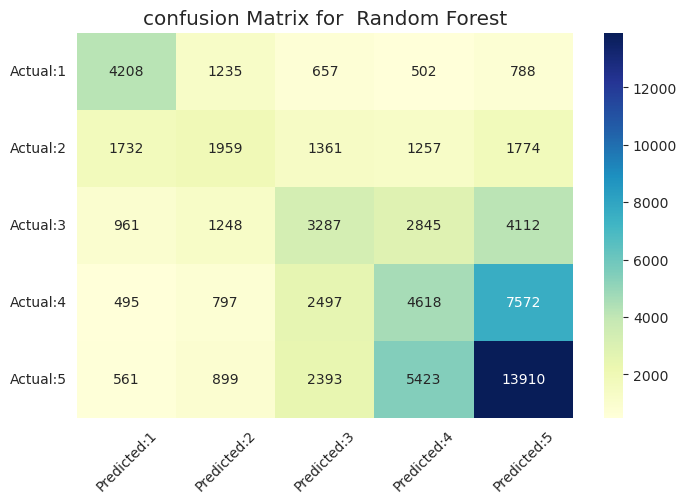

In [10]:
rf = RandomForestClassifier(n_estimators = 500,random_state = 1, max_depth=None,n_jobs=-1)
rf.fit(x_train,y_train)
rf_pred=rf.predict(x_test)
cm=confusion_matrix(y_test,rf_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2',
                                          'Predicted:3','Predicted:4','Predicted:5',],
                                         index=['Actual:1','Actual:2',
                                                'Actual:3','Actual:4','Actual:5'])
                                                                            
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
plt.title("confusion Matrix for  Random Forest")
plt.xticks(rotation=45)
plt.yticks(rotation=360)
plt.show()

In [11]:
print("-"*100)
print("Accuracy Score for Random Forest :",accuracy_score(y_test,rf_pred))
print("-"*100)
print("\n")
print("classification report for Random Forest :\n\n",classification_report(y_test, rf_pred))
print("-"*100)

----------------------------------------------------------------------------------------------------
Accuracy Score for Random Forest : 0.4170753156161035
----------------------------------------------------------------------------------------------------


classification report for Random Forest :

               precision    recall  f1-score   support

           1       0.53      0.57      0.55      7390
           2       0.32      0.24      0.28      8083
           3       0.32      0.26      0.29     12453
           4       0.32      0.29      0.30     15979
           5       0.49      0.60      0.54     23186

    accuracy                           0.42     67091
   macro avg       0.40      0.39      0.39     67091
weighted avg       0.40      0.42      0.41     67091

----------------------------------------------------------------------------------------------------


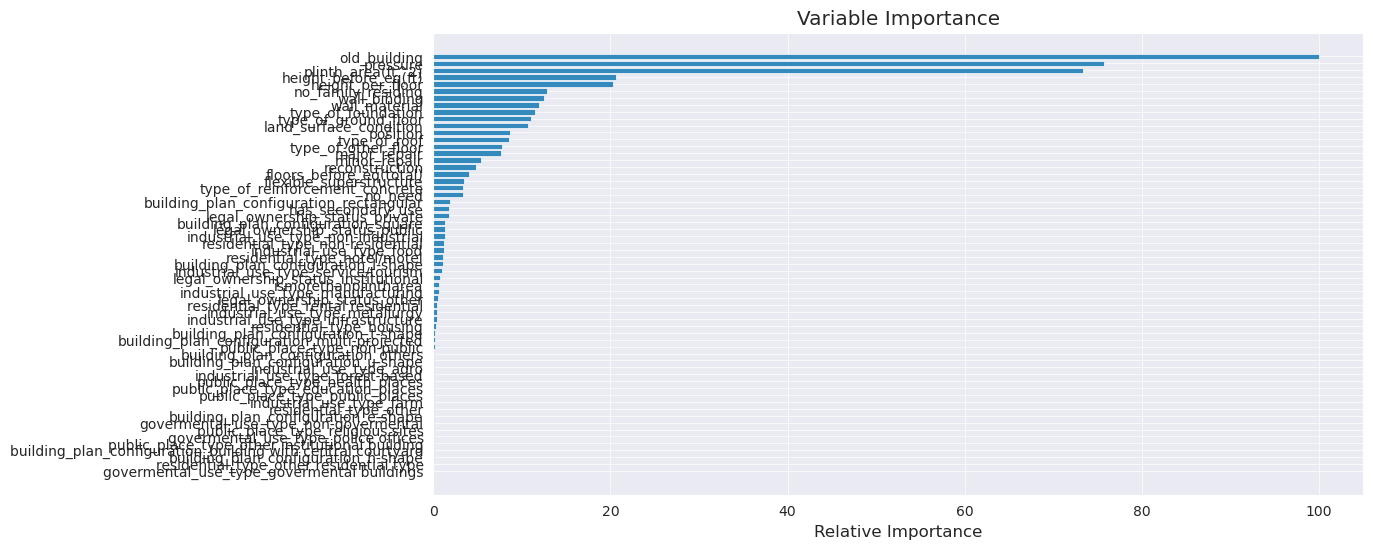

In [12]:
# plot feature importance

feature_importance = rf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# XGBoost

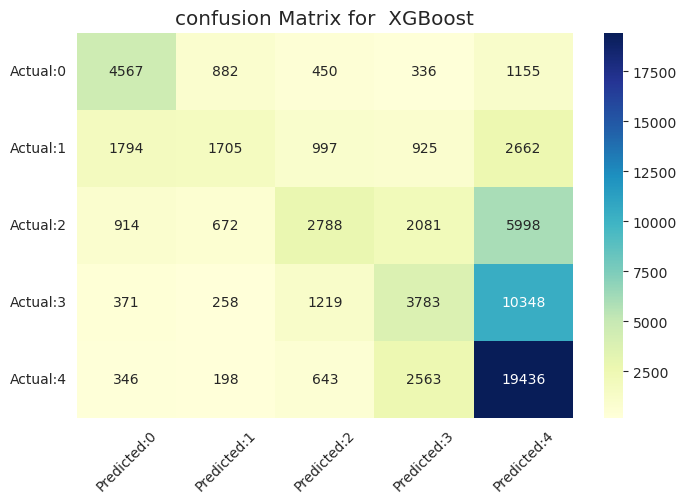

In [13]:
# try to use xgboost classifier

from xgboost import XGBClassifier

par = {'max_depth': 9, 
       'learning_rate': 0.09171368249775058, 
       'n_estimators': 759, 
       'min_child_weight': 1, 
       'gamma': 0.8941301203825416, 
       'subsample': 0.9235417357436105, 
       'colsample_bytree': 0.3938564995197662, 
       'reg_alpha': 0.5575094496034125, 
       'reg_lambda': 0.21515479375548496, 
       'max_delta_step': 1}

XGB = XGBClassifier(**par)

# change x_train from 1,2,3,4,5 to 0,1,2,3,4
y_train = y_train - 1
y_test = y_test - 1

XGB.fit(x_train, y_train)

xgb_pred = XGB.predict(x_test)
cm=confusion_matrix(y_test,xgb_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1',
                                          'Predicted:2','Predicted:3','Predicted:4',],
                                               index=['Actual:0','Actual:1',
                                                            'Actual:2','Actual:3','Actual:4'])

plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
plt.title("confusion Matrix for  XGBoost")
plt.xticks(rotation=45)
plt.yticks(rotation=360)
plt.show()

In [14]:
print("-"*100)
print("Accuracy Score for XGBoost :",accuracy_score(y_test,xgb_pred))
print("-"*100)
print("\n")
print("classification report for XGBoost :\n\n",classification_report(y_test, xgb_pred))
print("-"*100)

----------------------------------------------------------------------------------------------------
Accuracy Score for XGBoost : 0.48112265430534645
----------------------------------------------------------------------------------------------------


classification report for XGBoost :

               precision    recall  f1-score   support

           0       0.57      0.62      0.59      7390
           1       0.46      0.21      0.29      8083
           2       0.46      0.22      0.30     12453
           3       0.39      0.24      0.29     15979
           4       0.49      0.84      0.62     23186

    accuracy                           0.48     67091
   macro avg       0.47      0.43      0.42     67091
weighted avg       0.47      0.48      0.44     67091

----------------------------------------------------------------------------------------------------


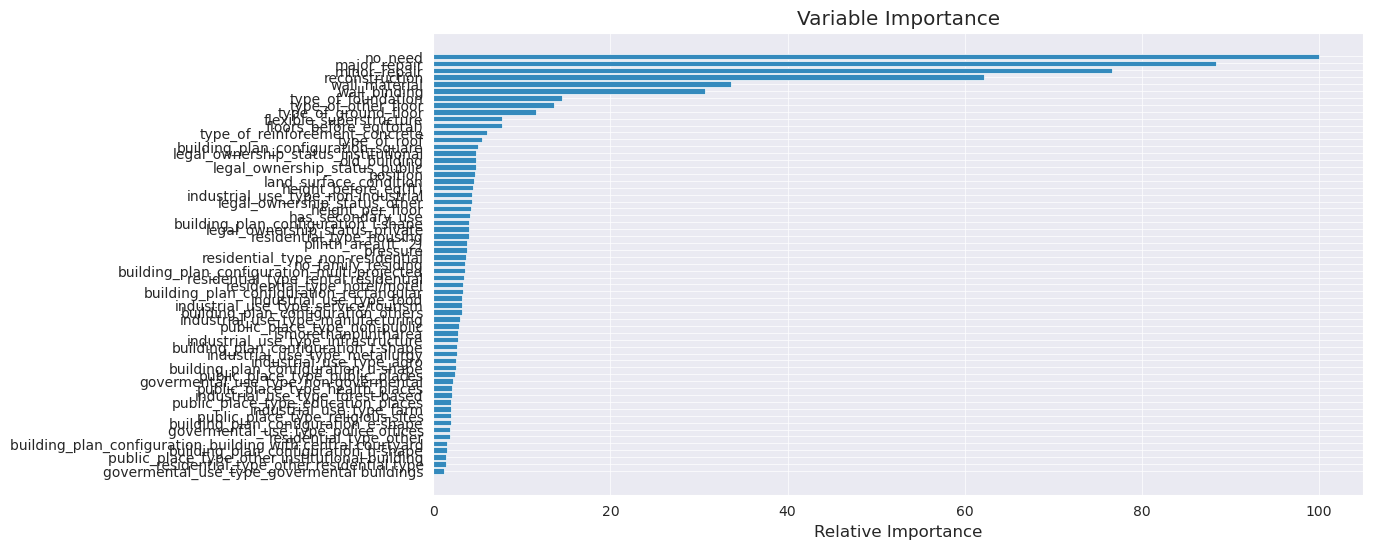

In [15]:
# plot feature importance

feature_importance = XGB.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
y_train = y_train + 1
y_test = y_test + 1
plt.show()

# Make predictions

In [16]:
# now predicting on test_data dataset
test_data=test_data.drop("id",axis=1)
xgb_pred_test_data=XGB.predict(test_data)

In [17]:
submission_sample_data=submission_sample_data.drop("damage_grade",axis=1)
xgb_pred_test_data=pd.DataFrame(xgb_pred_test_data)
submission_sample_data["damage_grade"]=xgb_pred_test_data + 1
submission_sample_data.head()

,id,damage_grade
0,0,5
1,1,5
2,2,5
3,3,4
4,4,2


In [18]:
submission_sample_data['damage_grade'].unique()

array([5, 4, 2, 1, 3])

In [19]:
submission_sample_data.to_csv('submission.csv', index=False)